Бакетное преобразование
Еще один подход, который очень часто применяется — бакетное преобразование. Надо разбить пользователей на n «корзинок» («бакетов»). Нужно гарантировать, что каждый пользователь попадет только в один бакет и пользователи по бакетам будут распределены равномерно. Это можно гарантировать с помощью того же хэширования с солью. О применении такого в Авито можно прочитать тут. Каждый бакет теперь становится как бы «метапользователем», участвующим в эксперименте. И внутри такого «метапользователя» показатель нужно как-то агрегировать.

Обычно вычисляют среднюю метрику в бакете, но можно, например, подсчитать медиану или какой-то квантиль. Скажем, если у нас 50 бакетов для теста и контроля, получается, будто мы тест проводим на группах по 50 метапользователей в каждой :)

В чем тут логика
Когда мы делим нашу исходную выборку на какое-то количество бакетов и считаем в каждом бакете, например, среднее, на выходе мы получаем выборку из 50-ти значений среднего по этим «метапользователям». Будто мы сделали бутстреп, но только не сгенерировав псевдовыборку, а откусив правильным образом кусок из имеющейся.

Поверх бакетного преобразования можно, например, применить стандартный t-тест (если примерно выполнены его предположения) или тест Манна-Уитни.

In [1]:
import pandahouse
import swifter
import hashlib
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import numpy as np

In [2]:
#подключение к серверу
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}


In [3]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2021-11-15' and '2021-11-21'
        and exp_group in (0,3)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = pandahouse.read_clickhouse(q, connection=connection)

#тест Манна-Уитни видит отличие
stats.mannwhitneyu(df[df.exp_group == 0].bucket_ctr, 
                   df[df.exp_group == 3].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=45.0, pvalue=1.0099815060146218e-16)

In [4]:
#и t-тест тоже

stats.ttest_ind(df[df.exp_group == 0].bucket_ctr, 
                   df[df.exp_group == 3].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=-14.755503007460415, pvalue=1.2278707215533271e-26)

<Axes: xlabel='bucket_ctr', ylabel='Count'>

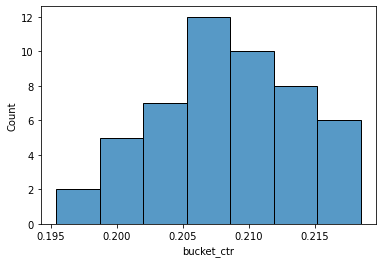

In [5]:
#Распределение бакетного CTR даже более-менее похоже на нормальное! 

sns.histplot(df[df.exp_group == 0].bucket_ctr)

<Axes: xlabel='ctr9', ylabel='Count'>

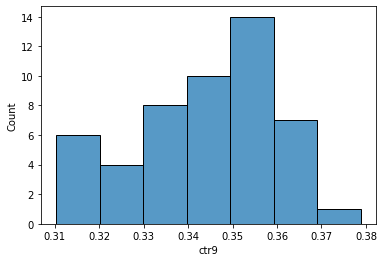

In [6]:
#А вот с квантилями пользовательских CTR стоит быть осторожнее, t-тест тут может работать не очень хорошо:

sns.histplot(df[df.exp_group == 3].ctr9)